# InceptionV3 on food-101 Dataset 

### Note: The experiments were done individually and finally concluded, and only the final results are explained in the notebook. The code for all the other experiments is available

### Experiments Performed: 

A series of experiments in each and every step of the training were performed to identify the ideal loss, ideal hyper-parameters and achieve better results
The experiments conducted are as follows:
    
    1.Choice of optimizer:
        a. SGD with momentum update # worked the best
        b. SGD with Nesterov Momentum update
        c. Adam
    2. Learning Rate Scheduling:
        a. Same learning rate
        b. Step Decay
        c. Polynomial Decay# works well initially
        d. Cyclical Learning Rate # used this finally
    3. Model Selection:
        a. Resnet50 - Tried, but took massive amounts of time per epoch, hence didn't proceed further
        b. InceptionV3 - Stuck with this model, and decreased image size to 96*96*3
    4. Transfer Learning Type
        a. Freeze Convolutional Base Model
        b. Train selected top layers in the base model
        c. Combination of steps a and b. # This model worked well in increasing validation accuracy
    5. Number of neurons and Dropout values
        a. 128 + 0.5
        b. 128 +0.25 # Used this combination, as others increased the number of parameters massively.
        c. 256 + 0.25
        d. 256 + 0.5
        e. 512 + 0.5
        f. 512 + 0.25
    6. GlobalAveragePooling2D vs GlobalMaxPooling2D: GlobalMaxPooling2D works better in acting as a regularization agent, as well improves the training accuracies when compared to GlobalAveragePooling2D.  
        

## Steps to be followed:

1. Split the Dataset into Train and Test(Done offline, before creating the notebook)
2. Define a model
3. Find ideal initial learning rate
4. Create a module for scheduling learning rate
5. Augment the Images
6. Apply the transformation(mean subtraction) for better fine-tuning
7. Test on a smaller set
8. Fit the model
9. Test the model on random images
10. Visualise the kernels to validate if the training has been successful.
11. Mention the resources followed

In [80]:
import keras.backend as K
from keras import regularizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.regularizers import l2
import keras 
import numpy as np
from imutils import paths
import cv2
import os
import keract

from keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, EarlyStopping

from keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


from lrs import config
from lrs.learningratefinder import LearningRateFinder
from lrs.clr_callback import CyclicLR

import matplotlib.pyplot as plt

import tensorflow as tf

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from collections import defaultdict
import collections
import os
from IPython.display import Image

The images have a very high iner- class variance, and thus there is a high correlation between classes. Thus, it becomes necessary to add more noise to the network, in the form of gaussian noise, as well as introduce regularization techniques, to avoid overfitting and mere memorization of the dataset. For example,

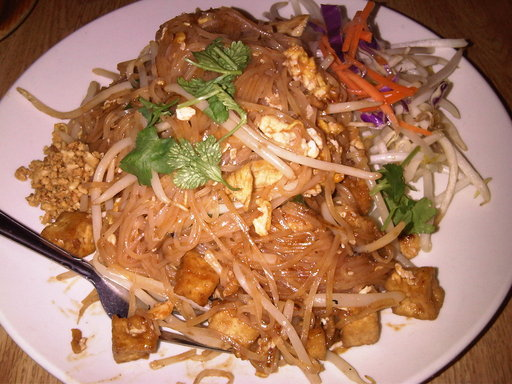

In [44]:
Image(filename="pad_thai.jpg")

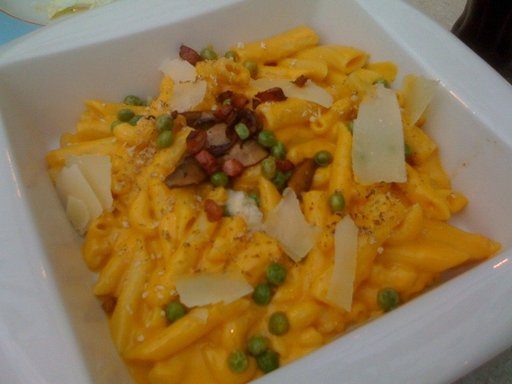

In [45]:
Image(filename="mac_and_cheese.jpg")

In [3]:
#Define all parameters used in the notebook here
NUM_EPOCHS = 100
INIT_LR = 5e-2
img_width, img_height = 96, 96
batch_size = 64

In [4]:
inception = InceptionV3(weights= 'imagenet' , include_top=False)
out = inception.output
out = GlobalMaxPooling2D()(out)
#out = Flatten(name="flatten")(out)
out = Dense(128,activation='relu')(out)
out = Dropout(rate = 0.3)(out)

predictions = Dense(101,kernel_regularizer=regularizers.l2(0), activation='softmax')(out)


model = Model(inputs=inception.input, outputs=predictions)
model.load_weights('best_model6.hdf5')
#experiment resulted in SGD being the better optimizer for this dataset
opt1=SGD(lr=INIT_LR, momentum=0.9,nesterov=False)
opt=Adam(lr=INIT_LR,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
for layer in inception.layers:
    layer.trainable= False
model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [131]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_881 (Conv2D)             (None, None, None, 3 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_881 (BatchN (None, None, None, 3 96          conv2d_881[0][0]                 
__________________________________________________________________________________________________
activation_880 (Activation)     (None, None, None, 3 0           batch_normalization_881[0][0]    
__________________________________________________________________________________________________
conv2d_882

### Augment the Images

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode="nearest",
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True)

test_datagen = ImageDataGenerator( rescale = 1.0/255.0)

val_datagen = ImageDataGenerator( rescale = 1.0/255.0)

#for mean subtraction, in RGB order, let's set the means values
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_datagen.mean = mean
val_datagen.mean = mean

In [5]:
training_set = train_datagen.flow_from_directory(
    './train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_set = val_datagen.flow_from_directory(
    './val', # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_set = test_datagen.flow_from_directory('./test',
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                         class_mode = 'categorical')

Found 68175 images belonging to 101 classes.
Found 7575 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


### Let's find initial Learning Rate 

In [8]:
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
		validation_set,
		1e-10, 1e+1,
		stepsPerEpoch=validation_set.samples // float(config.BATCH_SIZE),
		batchSize=config.BATCH_SIZE)

# plot the loss for the various learning rates and save the
# resulting plot to disk

# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")

[INFO] finding learning rate...
Instructions for updating:
Use tf.cast instead.
Epoch 1/18
118/118 [==============================] - 27s 231ms/step - loss: 12.1084 - acc: 0.0087
Epoch 2/18
118/118 [==============================] - 19s 165ms/step - loss: 12.1213 - acc: 0.0081
Epoch 3/18
118/118 [==============================] - 20s 166ms/step - loss: 12.1085 - acc: 0.0106
Epoch 4/18
118/118 [==============================] - 21s 180ms/step - loss: 12.1197 - acc: 0.0103
Epoch 5/18
118/118 [==============================] - 20s 171ms/step - loss: 12.1109 - acc: 0.0081
Epoch 6/18
118/118 [==============================] - 20s 172ms/step - loss: 12.1053 - acc: 0.0112
Epoch 7/18
118/118 [==============================] - 21s 176ms/step - loss: 12.1007 - acc: 0.0095
Epoch 8/18
118/118 [==============================] - 21s 179ms/step - loss: 12.0781 - acc: 0.0103
Epoch 9/18
118/118 [==============================] - 21s 181ms/step - loss: 12.0397 - acc: 0.0105
Epoch 10/18
118/118 [========

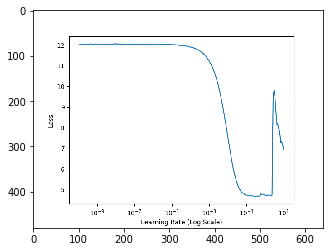

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('output\lrfind_plot.png')
imgplot = plt.imshow(img)
plt.show()

In [31]:
INIT_LR = 5e-2
NUM_EPOCHS = 50
stepSize = config.STEP_SIZE * (validation_set.samples // batch_size)
clr = CyclicLR(mode=config.CLR_METHOD,base_lr=2e-3, max_lr=5e-2,step_size=stepSize)

In [9]:
# callbacks
def poly_decay(epoch):
    maxEpochs=400
    baseLR = 0.05
    power= 1.0
    alpha= baseLR *(1- (epoch / float(maxEpochs)))**power
    print(alpha)
    return alpha

def poly_decay1(epoch):
    if(epoch<20):
        alpha = INIT_LR
        print(alpha)
    else:
        maxEpochs=NUM_EPOCHS
        baseLR = INIT_LR
        power= 1.2
        alpha= baseLR *(1- (epoch / float(maxEpochs)))**power
        print(alpha)
    return alpha

cp = ModelCheckpoint(filepath='saved_model.hdf5', verbose=1, save_best_only=True)
cp_sanity = ModelCheckpoint(filepath='saved_model_sanity.hdf5', verbose=1, save_best_only=False)
lr = LearningRateScheduler(poly_decay)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
log = CSVLogger("logfile.log")


### Perform Sanity checks

Make sure loss after first epoch is around -ln(1/n) as a safety metric... in this case n=101, hence, initial loss = 4.65

Overfit a tiny subset of data, to make sure the model fits the data

In [118]:
history = model.fit_generator(validation_set,
                             steps_per_epoch = validation_set.samples // batch_size,
                             epochs = 400,
                             verbose=1, 
                             callbacks =[LearningRateScheduler(poly_decay),cp_sanity])

Epoch 1/400
0.05
118/118 [==============================] - 27s 228ms/step - loss: 2.3639 - acc: 0.4756

Epoch 00001: saving model to saved_model_sanity.hdf5
Epoch 2/400
0.049875
118/118 [==============================] - 25s 213ms/step - loss: 2.2867 - acc: 0.4761

Epoch 00002: saving model to saved_model_sanity.hdf5
Epoch 3/400
0.04975
118/118 [==============================] - 29s 242ms/step - loss: 2.1648 - acc: 0.4980

Epoch 00003: saving model to saved_model_sanity.hdf5
Epoch 4/400
0.049625
118/118 [==============================] - 29s 244ms/step - loss: 2.1465 - acc: 0.4994

Epoch 00004: saving model to saved_model_sanity.hdf5
Epoch 5/400
0.0495
118/118 [==============================] - 28s 242ms/step - loss: 2.0616 - acc: 0.4998

Epoch 00005: saving model to saved_model_sanity.hdf5
Epoch 6/400
0.049375
118/118 [==============================] - 28s 238ms/step - loss: 2.0049 - acc: 0.5128

Epoch 00006: saving model to saved_model_sanity.hdf5
Epoch 7/400
0.04925
118/118 [======

118/118 [==============================] - 27s 230ms/step - loss: 0.6888 - acc: 0.7985

Epoch 00099: saving model to saved_model_sanity.hdf5
Epoch 100/400
0.037625
118/118 [==============================] - 27s 230ms/step - loss: 0.7685 - acc: 0.7878

Epoch 00100: saving model to saved_model_sanity.hdf5
Epoch 101/400
0.037500000000000006
118/118 [==============================] - 27s 230ms/step - loss: 0.7190 - acc: 0.7944

Epoch 00101: saving model to saved_model_sanity.hdf5
Epoch 102/400
0.037375000000000005
118/118 [==============================] - 27s 229ms/step - loss: 0.7119 - acc: 0.7957

Epoch 00102: saving model to saved_model_sanity.hdf5
Epoch 103/400
0.03725
118/118 [==============================] - 27s 229ms/step - loss: 0.7008 - acc: 0.7953

Epoch 00103: saving model to saved_model_sanity.hdf5
Epoch 104/400
0.037125
118/118 [==============================] - 27s 229ms/step - loss: 0.6677 - acc: 0.8043

Epoch 00104: saving model to saved_model_sanity.hdf5
Epoch 105/400
0.

118/118 [==============================] - 27s 230ms/step - loss: 0.5191 - acc: 0.8468

Epoch 00148: saving model to saved_model_sanity.hdf5
Epoch 149/400
0.0315
118/118 [==============================] - 27s 229ms/step - loss: 0.4927 - acc: 0.8576

Epoch 00149: saving model to saved_model_sanity.hdf5
Epoch 150/400
0.031375
118/118 [==============================] - 27s 229ms/step - loss: 0.5026 - acc: 0.8535

Epoch 00150: saving model to saved_model_sanity.hdf5
Epoch 151/400
0.03125
118/118 [==============================] - 27s 228ms/step - loss: 0.4992 - acc: 0.8537

Epoch 00151: saving model to saved_model_sanity.hdf5
Epoch 152/400
0.031125000000000003
118/118 [==============================] - 27s 230ms/step - loss: 0.5083 - acc: 0.8515

Epoch 00152: saving model to saved_model_sanity.hdf5
Epoch 153/400
0.031
118/118 [==============================] - 27s 229ms/step - loss: 0.5266 - acc: 0.8531

Epoch 00153: saving model to saved_model_sanity.hdf5
Epoch 154/400
0.030875
118/118 [=

118/118 [==============================] - 27s 229ms/step - loss: 0.2861 - acc: 0.9142

Epoch 00244: saving model to saved_model_sanity.hdf5
Epoch 245/400
0.019500000000000003
118/118 [==============================] - 27s 229ms/step - loss: 0.2697 - acc: 0.9160

Epoch 00245: saving model to saved_model_sanity.hdf5
Epoch 246/400
0.019375
118/118 [==============================] - 27s 229ms/step - loss: 0.2694 - acc: 0.9171

Epoch 00246: saving model to saved_model_sanity.hdf5
Epoch 247/400
0.019250000000000003
118/118 [==============================] - 27s 229ms/step - loss: 0.2833 - acc: 0.9190

Epoch 00247: saving model to saved_model_sanity.hdf5
Epoch 248/400
0.019125
118/118 [==============================] - 27s 229ms/step - loss: 0.2935 - acc: 0.9123

Epoch 00248: saving model to saved_model_sanity.hdf5
Epoch 249/400
0.019000000000000003
118/118 [==============================] - 27s 228ms/step - loss: 0.2954 - acc: 0.9116

Epoch 00249: saving model to saved_model_sanity.hdf5
Epo

118/118 [==============================] - 27s 229ms/step - loss: 0.1937 - acc: 0.9418

Epoch 00292: saving model to saved_model_sanity.hdf5
Epoch 293/400
0.013500000000000002
118/118 [==============================] - 27s 229ms/step - loss: 0.2048 - acc: 0.9371

Epoch 00293: saving model to saved_model_sanity.hdf5
Epoch 294/400
0.013374999999999998
118/118 [==============================] - 27s 229ms/step - loss: 0.1964 - acc: 0.9435

Epoch 00294: saving model to saved_model_sanity.hdf5
Epoch 295/400
0.013250000000000001
118/118 [==============================] - 27s 229ms/step - loss: 0.2234 - acc: 0.9376

Epoch 00295: saving model to saved_model_sanity.hdf5
Epoch 296/400
0.013124999999999998
118/118 [==============================] - 27s 228ms/step - loss: 0.2013 - acc: 0.9390

Epoch 00296: saving model to saved_model_sanity.hdf5
Epoch 297/400
0.013000000000000001
118/118 [==============================] - 27s 227ms/step - loss: 0.2084 - acc: 0.9349

Epoch 00297: saving model to sav

118/118 [==============================] - 29s 245ms/step - loss: 0.1425 - acc: 0.9596

Epoch 00386: saving model to saved_model_sanity.hdf5
Epoch 387/400
0.0017500000000000016
118/118 [==============================] - 29s 244ms/step - loss: 0.1483 - acc: 0.9563

Epoch 00387: saving model to saved_model_sanity.hdf5
Epoch 388/400
0.0016249999999999988
118/118 [==============================] - 29s 245ms/step - loss: 0.1238 - acc: 0.9641

Epoch 00388: saving model to saved_model_sanity.hdf5
Epoch 389/400
0.0015000000000000013
118/118 [==============================] - 29s 245ms/step - loss: 0.1508 - acc: 0.9570

Epoch 00389: saving model to saved_model_sanity.hdf5
Epoch 390/400
0.0013749999999999986
118/118 [==============================] - 29s 248ms/step - loss: 0.1504 - acc: 0.9554

Epoch 00390: saving model to saved_model_sanity.hdf5
Epoch 391/400
0.0012500000000000011
118/118 [==============================] - 29s 244ms/step - loss: 0.1392 - acc: 0.9581

Epoch 00391: saving model t

[INFO] evaluating network...


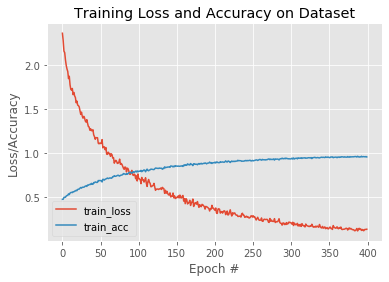

In [122]:
print("[INFO] evaluating network...")
#predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))
 
# plot the training loss and accuracy
N = 400
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


Since the loss value is nearly zero for the validation set without any regularization method, the model is suitable to be fit to a larger dataset, and clearly overfitting occurs in the latter case, which can be administered by the use of dropouts and regularizers in the ultimate and penultimate layers.

### Actual Model

In [132]:
def poly_decay(epoch):
    maxEpochs=50
    baseLR = 0.02
    power= 1.0
    alpha= baseLR *(1- (epoch / float(maxEpochs)))**power
    print(alpha)
    return alpha

In [133]:
model.load_weights('best_model6.hdf5')
model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

In [134]:
model.load_weights('saved_model.hdf5')
history = model.fit_generator(training_set,
                    steps_per_epoch = training_set.samples // batch_size,
                    validation_data=validation_set,
                    validation_steps=validation_set.samples // batch_size,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=[LearningRateScheduler(poly_decay),cp,es])

Epoch 1/50
0.02
1065/1065 [==============================] - 508s 477ms/step - loss: 2.1953 - acc: 0.5192 - val_loss: 2.1546 - val_acc: 0.5159

Epoch 00001: val_loss improved from 2.55252 to 2.15463, saving model to saved_model.hdf5
Epoch 2/50
0.0196
1065/1065 [==============================] - 499s 468ms/step - loss: 1.9945 - acc: 0.5401 - val_loss: 2.1642 - val_acc: 0.5120

Epoch 00002: val_loss did not improve from 2.15463
Epoch 3/50
0.0192
1065/1065 [==============================] - 504s 473ms/step - loss: 1.9923 - acc: 0.5422 - val_loss: 2.1389 - val_acc: 0.5175

Epoch 00003: val_loss improved from 2.15463 to 2.13894, saving model to saved_model.hdf5
Epoch 4/50
0.0188
1065/1065 [==============================] - 492s 462ms/step - loss: 1.9634 - acc: 0.5459 - val_loss: 2.1166 - val_acc: 0.5138

Epoch 00004: val_loss improved from 2.13894 to 2.11656, saving model to saved_model.hdf5
Epoch 5/50
0.0184
1065/1065 [==============================] - 492s 462ms/step - loss: 1.9714 - acc:

In [18]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from keras.optimizers import SGD


opt1=SGD(lr=INIT_LR, momentum=0.9,nesterov=False)
opt=Adam(lr=INIT_LR,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.load_weights("saved_model.hdf5")
model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
INIT_LR = 0.018
NUM_EPOCHS=100

def poly_decay1(epoch):
    maxEpochs=NUM_EPOCHS
    baseLR = INIT_LR
    power= 1.0

    alpha= baseLR *(1- (epoch / float(maxEpochs)))**power
    print(alpha)
    return alpha
#LearningRateScheduler(poly_decay) works
history = model.fit_generator(training_set,
                    steps_per_epoch = training_set.samples // batch_size,
                    validation_data=validation_set,
                    validation_steps=validation_set.samples // batch_size,
                    epochs=100,
                    verbose=1,
                    callbacks=[LearningRateScheduler(poly_decay1),log,cp])

Epoch 1/100
0.018
1065/1065 [==============================] - 336s 316ms/step - loss: 1.8791 - acc: 0.5381 - val_loss: 1.9997 - val_acc: 0.5069

Epoch 00001: saving model to saved_model.hdf5
Epoch 2/100
0.01782
1065/1065 [==============================] - 335s 315ms/step - loss: 1.8791 - acc: 0.5373 - val_loss: 2.0422 - val_acc: 0.5041

Epoch 00002: saving model to saved_model.hdf5
Epoch 3/100
0.01764
1065/1065 [==============================] - 332s 312ms/step - loss: 1.8593 - acc: 0.5423 - val_loss: 2.0043 - val_acc: 0.5218

Epoch 00003: saving model to saved_model.hdf5
Epoch 4/100
0.01746
1065/1065 [==============================] - 333s 313ms/step - loss: 1.8364 - acc: 0.5446 - val_loss: 1.9970 - val_acc: 0.5083

Epoch 00004: saving model to saved_model.hdf5
Epoch 5/100
0.017279999999999997
1065/1065 [==============================] - 335s 315ms/step - loss: 1.8202 - acc: 0.5484 - val_loss: 1.9982 - val_acc: 0.5164

Epoch 00005: saving model to saved_model.hdf5
Epoch 6/100
0.01709


Epoch 00041: saving model to saved_model.hdf5
Epoch 42/100
0.010620000000000001
1065/1065 [==============================] - 332s 312ms/step - loss: 1.4811 - acc: 0.6186 - val_loss: 2.0922 - val_acc: 0.5214

Epoch 00042: saving model to saved_model.hdf5
Epoch 43/100
0.01044
1065/1065 [==============================] - 332s 312ms/step - loss: 1.4736 - acc: 0.6197 - val_loss: 2.0741 - val_acc: 0.5247

Epoch 00043: saving model to saved_model.hdf5
Epoch 44/100
0.01026
1065/1065 [==============================] - 332s 312ms/step - loss: 1.4720 - acc: 0.6221 - val_loss: 2.1036 - val_acc: 0.5124

Epoch 00044: saving model to saved_model.hdf5
Epoch 45/100
0.01008
1065/1065 [==============================] - 333s 313ms/step - loss: 1.4660 - acc: 0.6210 - val_loss: 2.0875 - val_acc: 0.5207

Epoch 00045: saving model to saved_model.hdf5
Epoch 46/100
0.0099
1065/1065 [==============================] - 332s 312ms/step - loss: 1.4524 - acc: 0.6245 - val_loss: 2.0974 - val_acc: 0.5244

Epoch 00046:


Epoch 00082: saving model to saved_model.hdf5
Epoch 83/100
0.0032400000000000007
1065/1065 [==============================] - 333s 313ms/step - loss: 1.2241 - acc: 0.6788 - val_loss: 2.2088 - val_acc: 0.5166

Epoch 00083: saving model to saved_model.hdf5
Epoch 84/100
0.0030600000000000007
1065/1065 [==============================] - 333s 313ms/step - loss: 1.2177 - acc: 0.6803 - val_loss: 2.2070 - val_acc: 0.5151

Epoch 00084: saving model to saved_model.hdf5
Epoch 85/100
0.00288
1065/1065 [==============================] - 334s 314ms/step - loss: 1.2133 - acc: 0.6794 - val_loss: 2.2337 - val_acc: 0.5106

Epoch 00085: saving model to saved_model.hdf5
Epoch 86/100
0.0027
1065/1065 [==============================] - 333s 313ms/step - loss: 1.2088 - acc: 0.6822 - val_loss: 2.2249 - val_acc: 0.5155

Epoch 00086: saving model to saved_model.hdf5
Epoch 87/100
0.00252
1065/1065 [==============================] - 333s 313ms/step - loss: 1.2002 - acc: 0.6834 - val_loss: 2.2543 - val_acc: 0.507

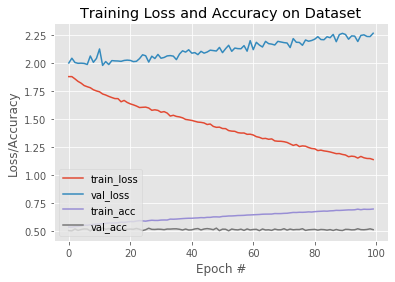

In [21]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


The figure shows that the training accuracy is high, wheras the validation accuracy is low. Thus, adding regularization techniques is necessary to avoid overfitting. Dropout is applied to manage the same. 

In [6]:
inception = InceptionV3(weights= None , include_top=False)
out = inception.output
out = GlobalMaxPooling2D()(out)
out = Dropout(rate = 0.25)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(rate = 0.3)(out)

predictions = Dense(101, activation='softmax')(out)


model = Model(inputs=inception.input, outputs=predictions)
model.load_weights('saved_model.hdf5')
#experiment resulted in SGD being the better optimizer for this dataset
opt1=SGD(lr=INIT_LR, momentum=0.8,nesterov=False)
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True

model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Cyclical Learning Rate 

During training, the validation loss did not decrease irrespective of the variation in initial learning rate. Hence, I assumed that the cost function must have hit a local minimum, and to get it out of there, I used cyclical learning rate which actually performed much better than before.

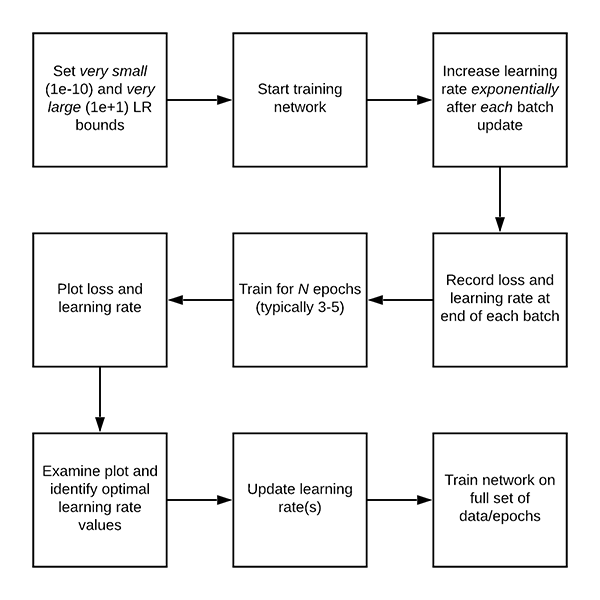

Source: pyimagesearch

To find the minimum and maximum learning rates, I used the method I had used earlier to detect the inital learning rate. The graph I got is as follows. I ran the code locally

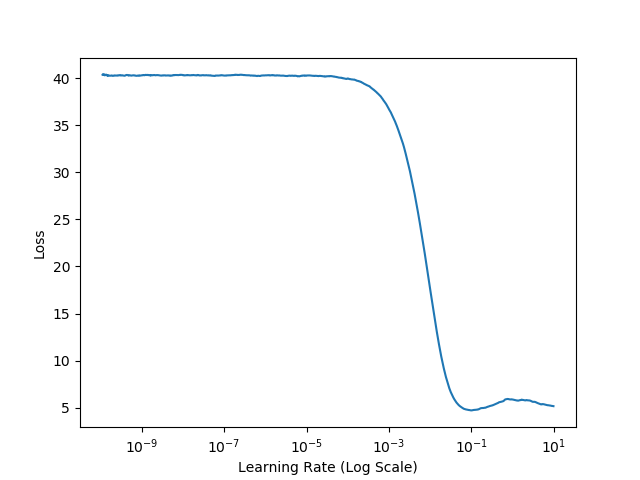

In [32]:
INIT_LR = 6.75e-4
NUM_EPOCHS=30
stepSize = config.STEP_SIZE * (training_set.samples // batch_size)
clr = CyclicLR(mode=config.CLR_METHOD,base_lr=9e-4, max_lr=5e-3,step_size=stepSize)

def poly_decay1(epoch):
    maxEpochs=NUM_EPOCHS
    baseLR = INIT_LR
    power= 1.0

    alpha= baseLR *(1- (epoch / float(maxEpochs)))**power
    print(alpha)
    return alpha
#LearningRateScheduler(poly_decay) works

history = model.fit_generator(training_set,
                    steps_per_epoch = training_set.samples // batch_size,
                    validation_data=validation_set,
                    validation_steps=validation_set.samples // batch_size,
                    epochs= NUM_EPOCHS,
                    verbose=1,
                    callbacks=[clr,cp])
#LearningRateScheduler(poly_decay1)

Epoch 1/30
1065/1065 [==============================] - 344s 323ms/step - loss: 1.7198 - acc: 0.5766 - val_loss: 1.9398 - val_acc: 0.5343

Epoch 00001: val_loss improved from 1.94500 to 1.93975, saving model to saved_model.hdf5
Epoch 2/30
1065/1065 [==============================] - 340s 320ms/step - loss: 1.7256 - acc: 0.5749 - val_loss: 1.9668 - val_acc: 0.5288

Epoch 00002: val_loss did not improve from 1.93975
Epoch 3/30
1065/1065 [==============================] - 339s 318ms/step - loss: 1.7338 - acc: 0.5761 - val_loss: 1.9463 - val_acc: 0.5296

Epoch 00003: val_loss did not improve from 1.93975
Epoch 4/30
 286/1065 [=======>......................] - ETA: 3:47 - loss: 1.7136 - acc: 0.5750

KeyboardInterrupt: 

Text(0, 0.5, 'Learning Rate')

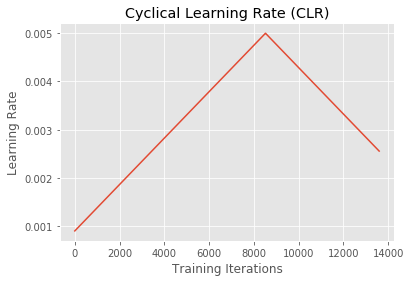

In [31]:
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")


## Results

### Output and accuracy from freezing base- model - 180 epochs

The reason why I didn't proceed with this is due to the saturation of validation_loss, even thoough I changed all the hyperparameters and also tried various Learning rate scheduling techniques, it's performance was stuck consistently at a lower value.

In [48]:
model.load_weights('best_model6.hdf5')
model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
model.evaluate_generator(test_set, steps=test_set.samples // 64, verbose=1)

394/394 [==============================] - 77s 195ms/step


[1.7826662216006284, 0.5807591519145243]

In [68]:
with tf.Session() as sess:
    print("Accuracy with around 180 epochs is: ",Out[49][1]*100)
    sess.close()

Accuracy with around 180 epochs is:  58.07591519145243


### Output and accuracy with fine-tuning of top-layers in base model - ~100 epochs ( Due to time constraint)

In [50]:
model.load_weights('saved_model.hdf5')
model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

In [51]:
model.evaluate_generator(test_set, steps=test_set.samples // 64, verbose=1)

394/394 [==============================] - 74s 189ms/step


[1.6880949590617553, 0.5876280473562795]

In [69]:
with tf.Session() as sess:
    print("Accuracy with around 100 epochs is: ",Out[51][1]*100)
    sess.close()

Accuracy with around 100 epochs is:  58.76280473562795


In [51]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict)

{'input_9': <keras.engine.input_layer.InputLayer object at 0x000001FCFFF55D68>, 'conv2d_753': <keras.layers.convolutional.Conv2D object at 0x000001FD0A252B00>, 'batch_normalization_753': <keras.layers.normalization.BatchNormalization object at 0x000001FD0A0EF358>, 'activation_753': <keras.layers.core.Activation object at 0x000001FD0A22D5C0>, 'conv2d_754': <keras.layers.convolutional.Conv2D object at 0x000001FD0A0DBB38>, 'batch_normalization_754': <keras.layers.normalization.BatchNormalization object at 0x000001FD09EDE198>, 'activation_754': <keras.layers.core.Activation object at 0x000001FD09FA8198>, 'conv2d_755': <keras.layers.convolutional.Conv2D object at 0x000001FCEC9E8400>, 'batch_normalization_755': <keras.layers.normalization.BatchNormalization object at 0x000001FCECAAF0F0>, 'activation_755': <keras.layers.core.Activation object at 0x000001FCECA0AC18>, 'max_pooling2d_33': <keras.layers.pooling.MaxPooling2D object at 0x000001FCF93B8DA0>, 'conv2d_756': <keras.layers.convolutional.

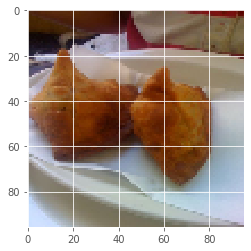

In [75]:
food_list=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

img = image.load_img("samosa.jpg", target_size=(96, 96))
image1=img
img = image.img_to_array(img)                    
img = np.expand_dims(img, axis=0)         
img /= 255.
yhat = model.predict(img)
index = np.argmax(yhat)
food_list.sort()
pred_value = food_list[index]
imgplot = plt.imshow(image1)
plt.show()

In [76]:
print("Predicted value: ",pred_value)

Predicted value:  samosa


input_9:0 (96, 96, 3) -> Skipped. First dimension is not 1.
conv2d_753/convolution:0 (1, 47, 47, 32) 


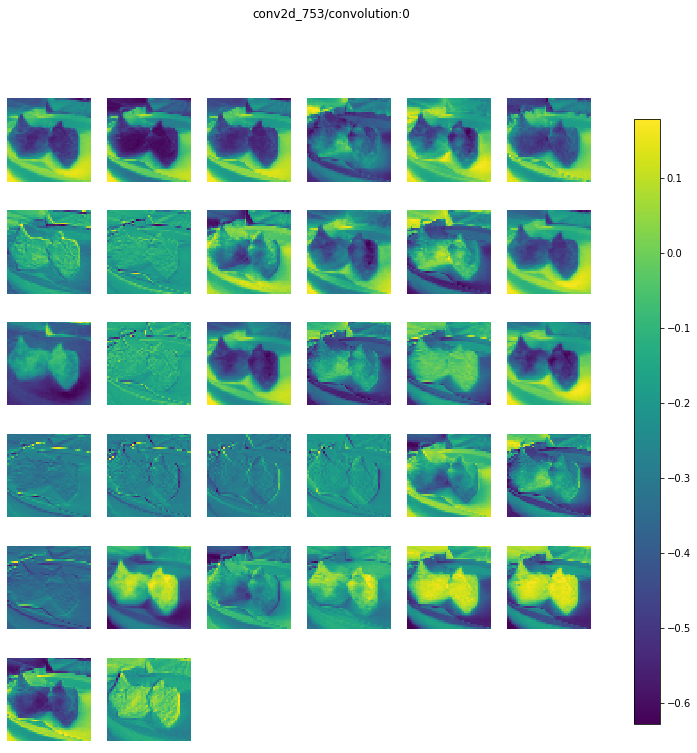

batch_normalization_753/cond/Merge:0 (1, 47, 47, 32) 


KeyboardInterrupt: 

In [75]:
activations = keract.get_activations(model, img)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)

#### The smooth kernels show that the network is learning and hence has predicted correctly

Let's consider another image that is predicted incorrectly

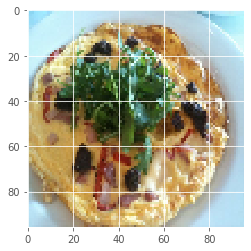

In [77]:
food_list=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

img = image.load_img("omelette.jpg", target_size=(96, 96))
image1=img
img = image.img_to_array(img)                    
img = np.expand_dims(img, axis=0)         
img /= 255.
yhat = model.predict(img)
index = np.argmax(yhat)
food_list.sort()
pred_value = food_list[index]
imgplot = plt.imshow(image1)
plt.show()

In [78]:
print("Predicted value: ",pred_value)

Predicted value:  spaghetti_carbonara


input_1:0 (96, 96, 3) -> Skipped. First dimension is not 1.
conv2d_1/convolution:0 (1, 47, 47, 32) 


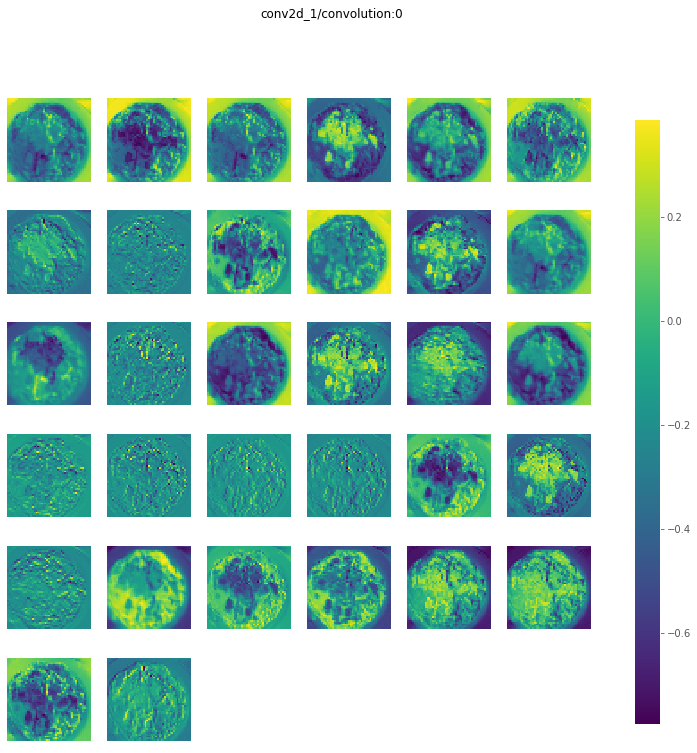

batch_normalization_1/cond/Merge:0 (1, 47, 47, 32) 


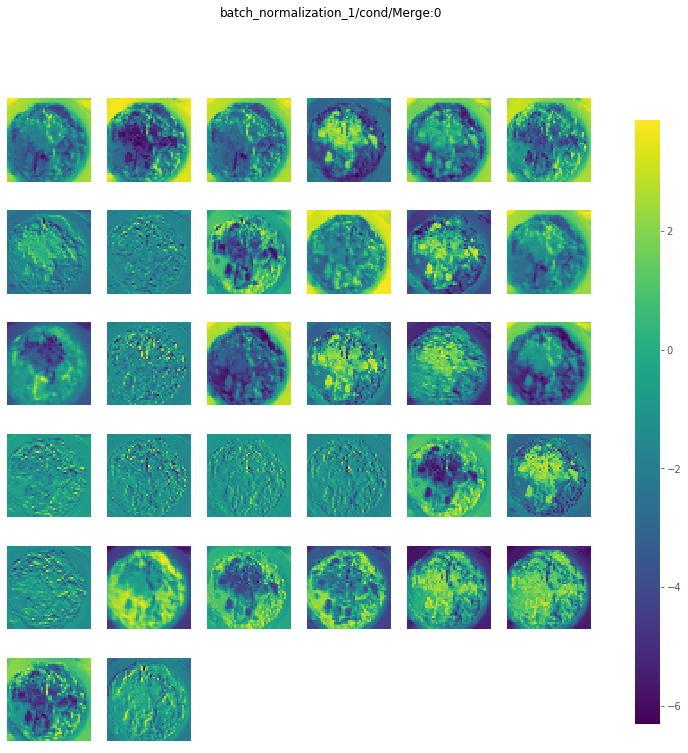

activation_1/Relu:0 (1, 47, 47, 32) 


KeyboardInterrupt: 

In [81]:
activations = keract.get_activations(model, img)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)

### The kernels are noisy and hence, might be the reason for the incorrect prediction

## Additional Actions to be taken
    1. Add Gausian Noise to the model and check 
    2. Let the model train for some more epochs
    3. Study more about other ways of regularizations, apart from dropout, image augmentation and addition of gaussiannoise.

## Sources
    1. https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
    2. https://keras.io/applications/#usage-examples-for-image-classification-models
    3. https://github.com/philipperemy/keract
    4. https://www.youtube.com/watch?v=C86ZXvgpejM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=17